<a href="https://colab.research.google.com/github/lhaven-dev/TP_DATA/blob/main/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Create a SparkSession
spark = SparkSession.builder.appName("NetflixData").getOrCreate()

# Read the CSV file into a DataFrame
netflix_df = spark.read.csv("/content/netflix1.csv", header=True, inferSchema=True)

In [84]:
# List of values to consider as empty or non-significant
empty_values = ["Not Given", "N/A", ""]

# Replace empty values with null for all columns
for column in netflix_df.columns:
    for value in empty_values:
        netflix_df = netflix_df.withColumn(column, when(col(column) == value, None).otherwise(col(column)))

In [85]:
# Convert a small sample of the PySpark DataFrame to Pandas DataFrame
sample_pandas_df = netflix_df.limit(50).toPandas()  # Limit to the first 50 rows

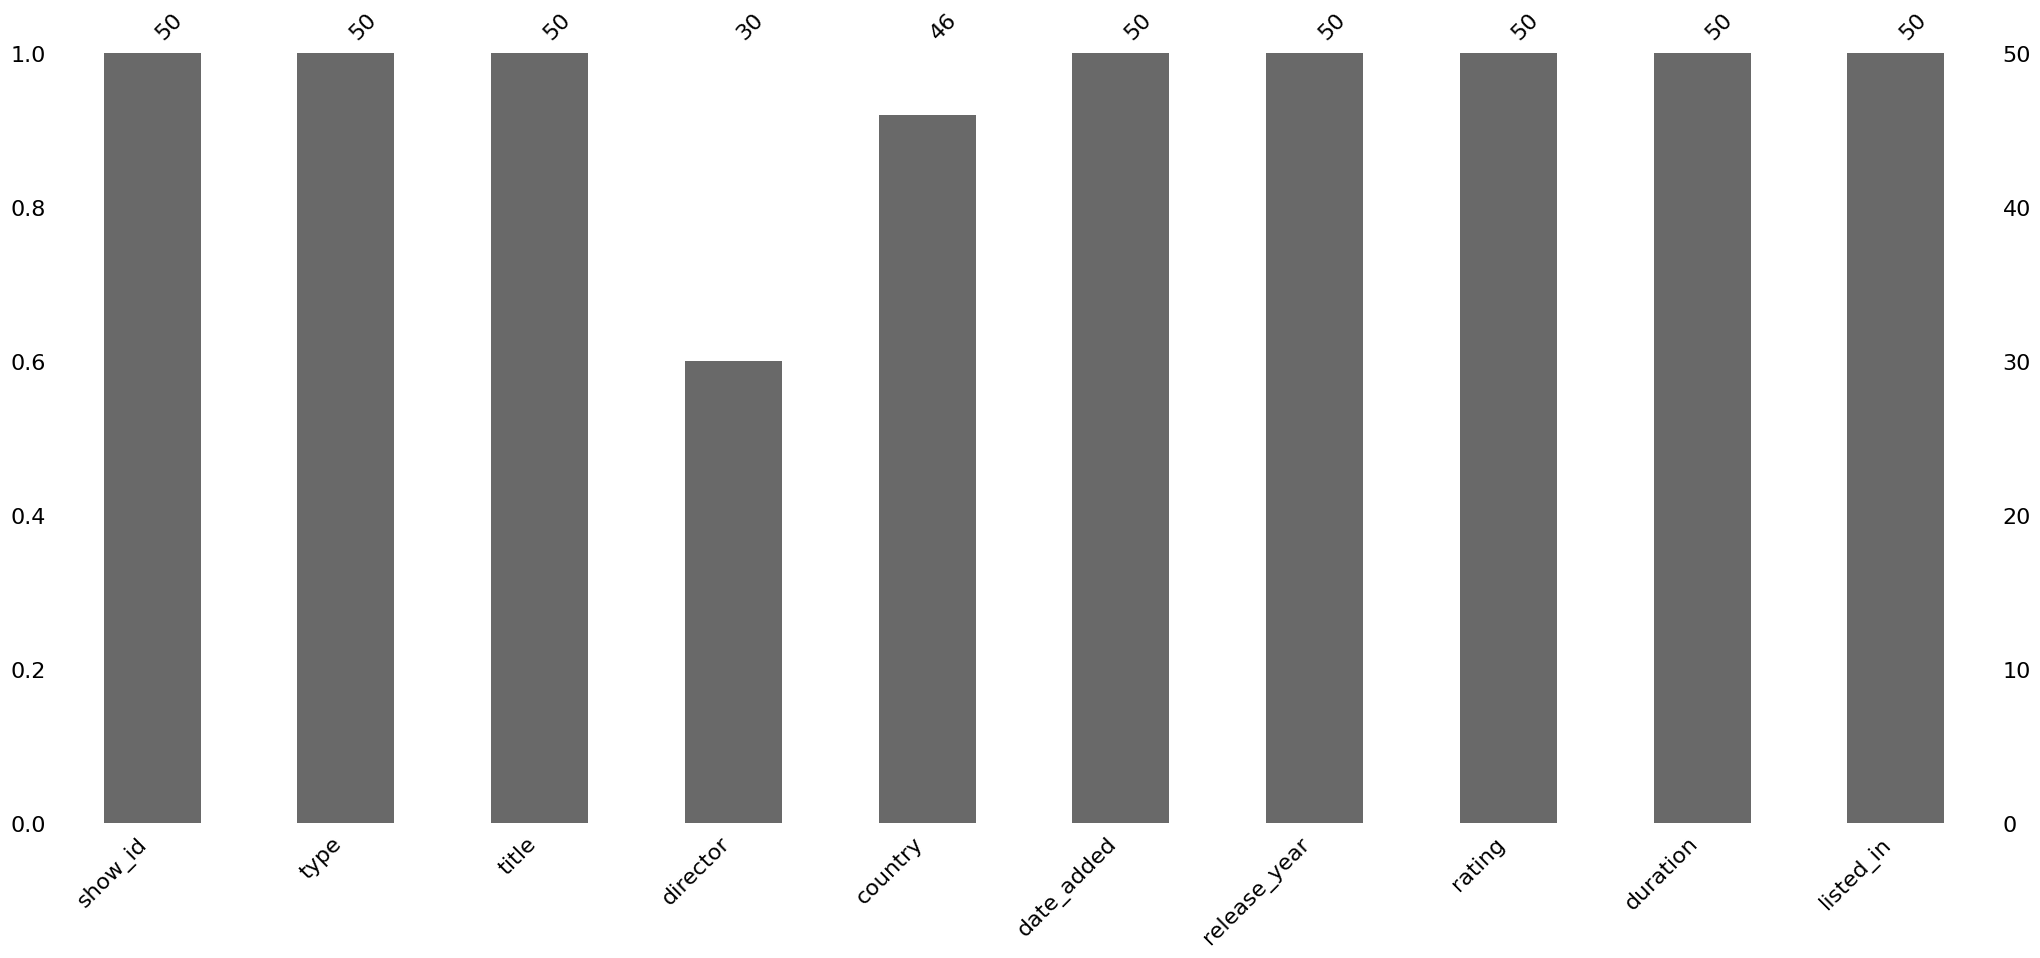

In [86]:
import missingno as msno
import matplotlib.pyplot as plt

# Visualize missing values using msno.bar()
msno.bar(sample_pandas_df)
plt.show()

# Interpretation:
# The bar chart displays the number of non-missing values for each column.
# Columns with shorter bars have more missing values.  Identify the shortest bars to pinpoint the columns with the most missing data ( actually , director and country ).

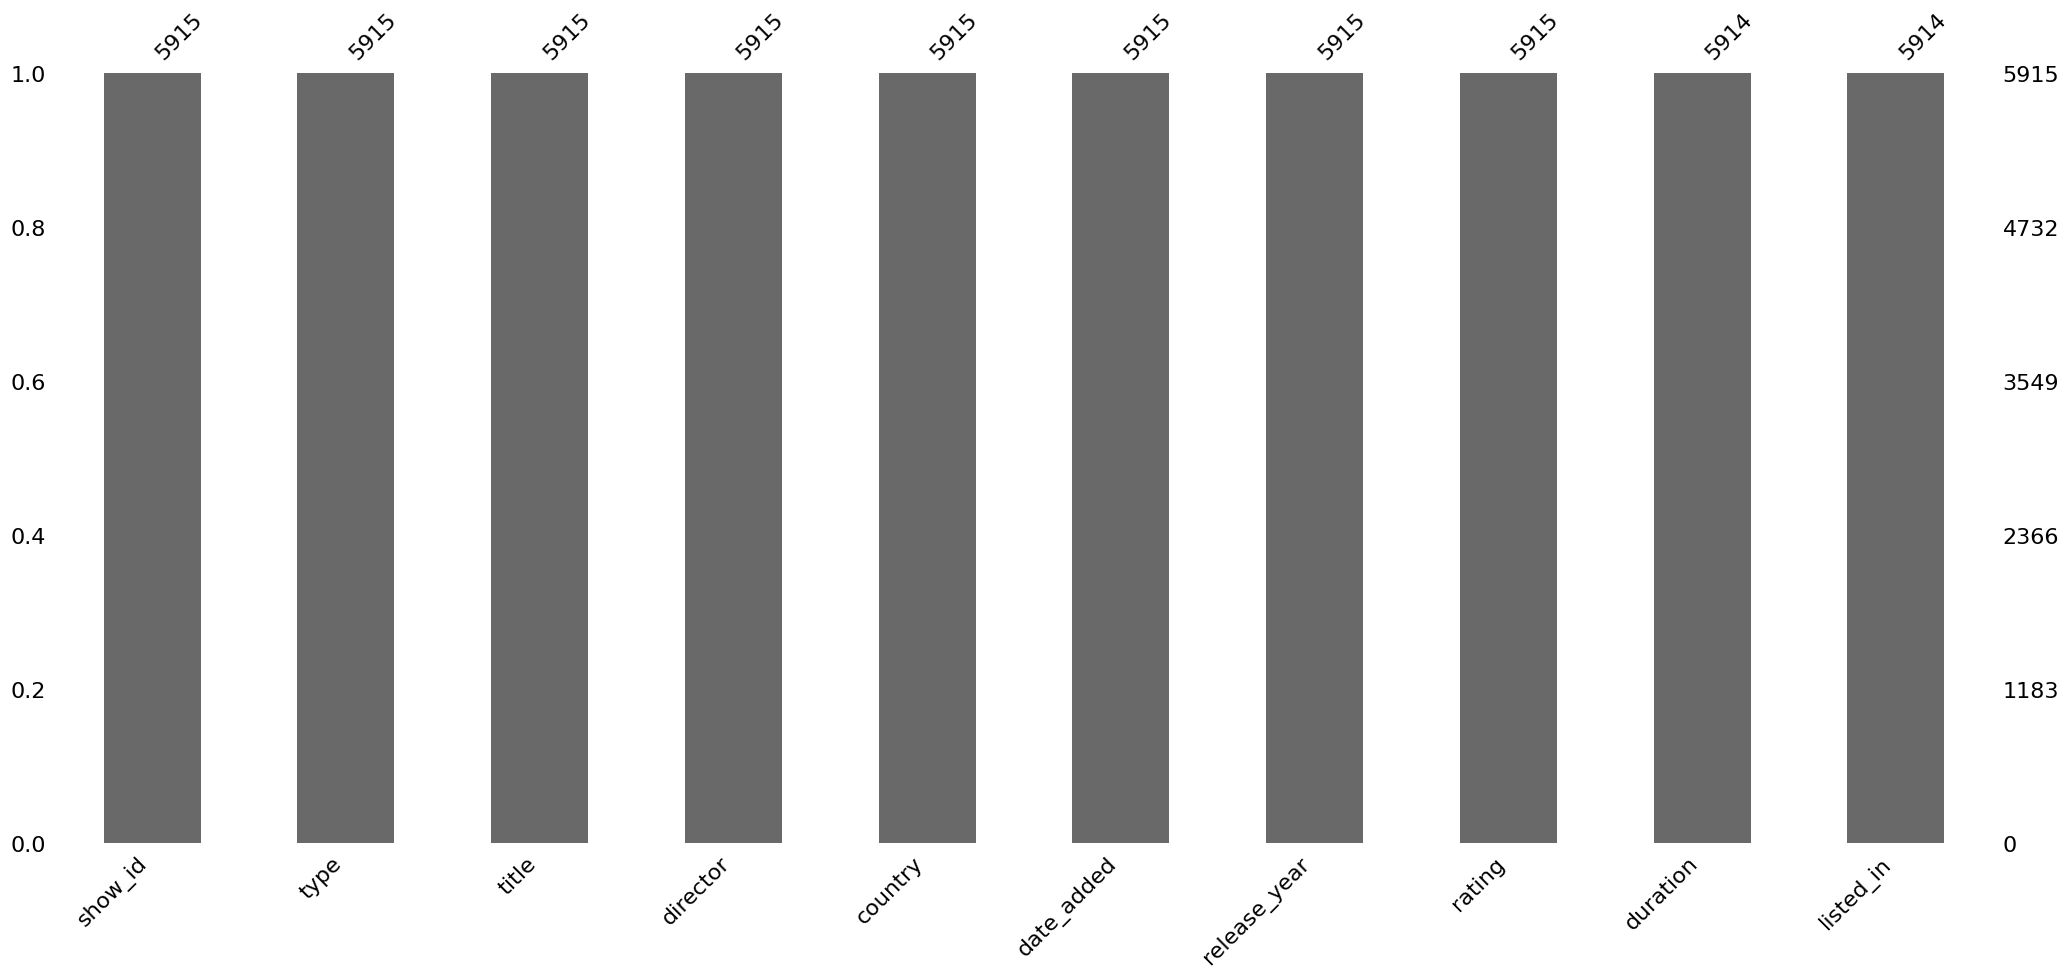

In [87]:
# Drop rows with missing values in 'director' or 'country' columns
required_columns = ['director', 'country']
netflix_df_clean = netflix_df.dropna(subset=required_columns)
sample_pandas_df = netflix_df_clean.limit(8000).toPandas()  # Limit to the first 50 rows
msno.bar(sample_pandas_df)
plt.show()

# Interpretation:
# The bar chart displays the number of non-missing values for each column.
# Columns with shorter bars have more missing values.  now , they have all the same numbers of values , so its clean

In [88]:
from pyspark.sql.functions import split, explode

# Split the 'listed_in' column by the comma delimiter
netflix_df_clean = netflix_df_clean.withColumn("listed_in_array", split(col("listed_in"), ", "))

# Explode the array to create separate rows for each category
netflix_df_exploded = netflix_df_clean.withColumn("category", explode(col("listed_in_array")))

# Show the DataFrame with the exploded categories
netflix_df_exploded.select("title", "category").show(truncate=False)

+--------------------------------+------------------------+
|title                           |category                |
+--------------------------------+------------------------+
|Dick Johnson Is Dead            |Documentaries           |
|Ganglands                       |Crime TV Shows          |
|Ganglands                       |International TV Shows  |
|Ganglands                       |TV Action & Adventure   |
|Midnight Mass                   |TV Dramas               |
|Midnight Mass                   |TV Horror               |
|Midnight Mass                   |TV Mysteries            |
|Confessions of an Invisible Girl|Children & Family Movies|
|Confessions of an Invisible Girl|Comedies                |
|Sankofa                         |Dramas                  |
|Sankofa                         |Independent Movies      |
|Sankofa                         |International Movies    |
|The Great British Baking Show   |British TV Shows        |
|The Great British Baking Show   |Realit

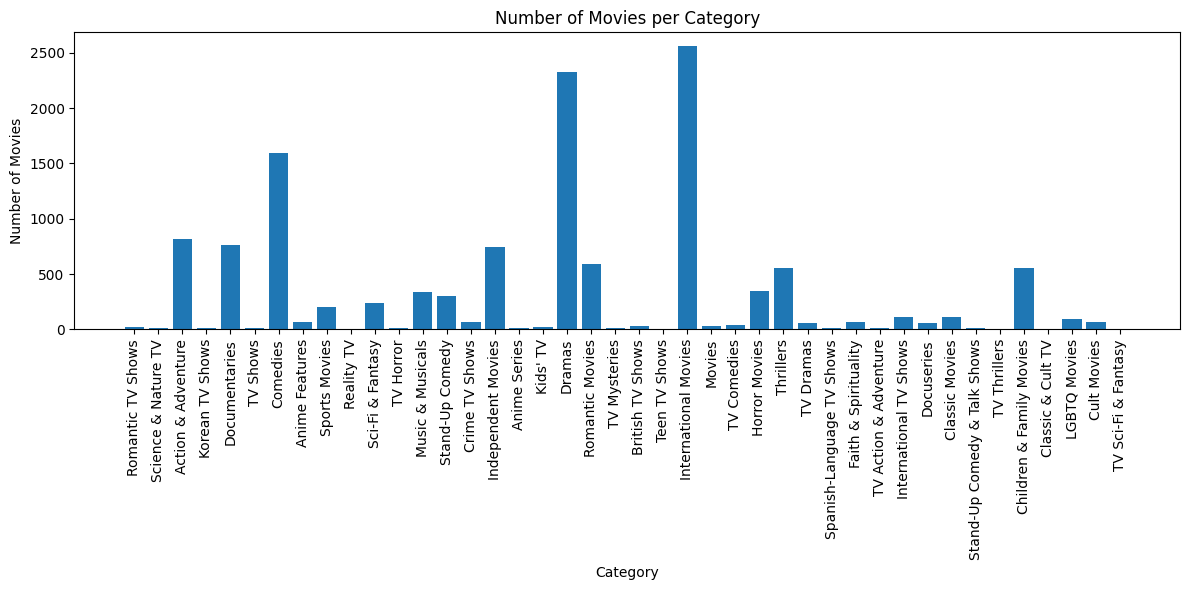

In [89]:
# Group by category and count the number of movies
category_counts = netflix_df_exploded.groupBy("category").agg(count("*").alias("movie_count"))

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
category_counts_pandas = category_counts.toPandas()

# Create the bar plot
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(category_counts_pandas["category"], category_counts_pandas["movie_count"])
plt.xlabel("Category")
plt.ylabel("Number of Movies")
plt.title("Number of Movies per Category")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [90]:
# Order the DataFrame by 'release_year'
netflix_df_clean = netflix_df_clean.orderBy("release_year")
# Show the DataFrame with the release year in order
netflix_df_clean.select("title", "release_year").show(truncate=False)

+---------------------------------------------+------------+
|title                                        |release_year|
+---------------------------------------------+------------+
|Prelude to War                               |1942        |
|The Battle of Midway                         |1942        |
|Undercover: How to Operate Behind Enemy Lines|1943        |
|Why We Fight: The Battle of Russia           |1943        |
|WWII: Report from the Aleutians              |1943        |
|The Negro Soldier                            |1944        |
|Tunisian Victory                             |1944        |
|Know Your Enemy - Japan                      |1945        |
|Nazi Concentration Camps                     |1945        |
|San Pietro                                   |1945        |
|Let There Be Light                           |1946        |
|Pioneers of African-American Cinema          |1946        |
|Thunderbolt                                  |1947        |
|White Christmas        

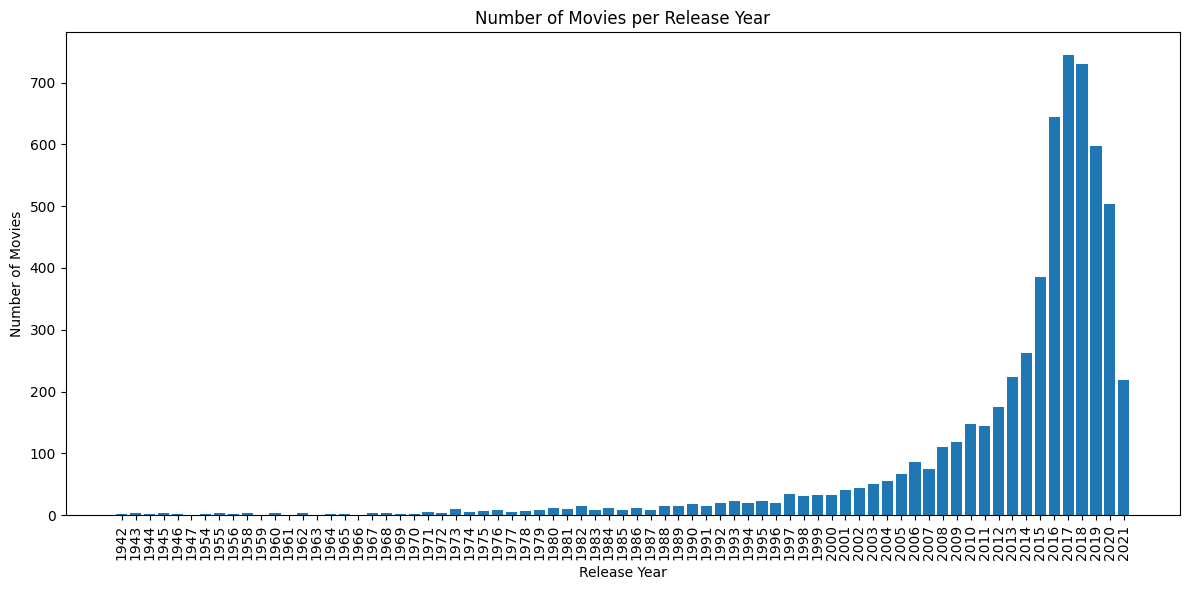

In [91]:
import matplotlib.pyplot as plt

# Group by release year and count the number of movies
netflix_df_clean = netflix_df_clean.filter(~col("release_year").contains("min")) # here i see somes issue , one row have like "40 min" for date , so i clean my df before draw my charts
release_year_counts = netflix_df_clean.groupBy("release_year").count()

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
release_year_counts_pandas = release_year_counts.toPandas()

# Sort the Pandas DataFrame by release year
release_year_counts_pandas = release_year_counts_pandas.sort_values("release_year")

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(release_year_counts_pandas["release_year"], release_year_counts_pandas["count"])
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.title("Number of Movies per Release Year")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()